In [1]:
%%capture
!pip install wordcloud
!pip install pyLDAvis

In [2]:
%%capture
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
import regex as re
from nltk import download, FreqDist
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')

In [3]:
stop_words=stopwords.words('english')

In [20]:
tweets_df = pd.read_csv('global_warming_tweets.csv', lineterminator='\n')

In [95]:
tweets_df.head(5)

,date,content,id,retweetCount,hashtags,Positive Score,Neutral Score,Negative Score,Polarity,Sentiment,Tokenised,Topic
0,2018-03-30,If the Brigade would respect science they would come to understand that all temperature patterns measured thus far have proved to be within natural vacillations and should realize that Manmade is just a silly parcel of hot air,979868635056414720,0,"['FlatEarth', 'Climatard', 'GlobalWarming', 'leftwing']",0.165,0.835,0.000,0.6908,Positive,"[brigade, would, respect, science, would, come, understand, temperature, patterns, measured, thus, far, proved, within, natural, vacillations, realize, manmade, silly, parcel, hot, air]",1.0
1,2018-03-30,RT Questions about you were too embarrassed to ask,979867626557071361,1,"['Climatechange', 'globalwarming', 'sustainability', 'CleanPowerPlan', 'ParisAgreement', 'greenhousegases', 'environment', 'carbon', 'extremeweather', 'energy']",0.000,0.762,0.238,-0.3612,Negative,"[questions, embarrassed, ask]",0.0
2,2018-03-30,Land ambush,979865304493969408,2,"['FreeSunTree', 'LandDefender', 'Secwepemc', 'Unceded', 'Illegal', 'StopKM', 'ProtectTheInlet', 'GlobalWarming', 'UNDRIP', 'BurnabyMountain', 'BCpoli', 'Vanpoli', 'Burnaby', 'ABleg', 'Skpoli', 'Onpoli', 'Wapoli', 'PoliQC', 'Coquitlam', 'NorthVan', 'Surrey', 'MapleRidge', 'NoDAPL', 'NoKXL', 'Cdnpoli']",0.000,1.000,0.000,0.0000,Neutral,"[land, ambush]",5.0
3,2018-03-30,so desperate liars\n is an enormous,979863802920435712,0,"['OMG', 'GlobalWarming', 'hoax']",0.000,0.389,0.611,-0.7408,Negative,"[desperate, liars, enormous]",0.0
4,2018-03-30,arent enough you to plague the world with \n\n the taxpayer ripoff thief is now getting away with MORE than just his K soundproof phone booth amp hightech locks\n\n \n\n,979863583159758848,2,"['Climatechange', 'GlobalWarming', 'FirePruitt']",0.000,0.884,0.116,-0.5267,Negative,"[arent, enough, plague, world, taxpayer, ripoff, thief, getting, away, k, soundproof, phone, booth, hightech, locks]",4.0


In [22]:
tweets_df = tweets_df.loc[:, ~tweets_df.columns.str.contains('^Unnamed')]

In [23]:
tweets_df = tweets_df.dropna()

In [24]:
tweets_df.shape

(892957, 5)

In [25]:
# Remove emojis

def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

In [26]:
# remove punctuations

def clean_tweets(tweet):
  # 
  # lowercase the text
  # tweet = tweet.lower()
  # print('tweets:::', type(tweet)) 
  # remove mentions
    tweet = re.sub('@[\w]*','',tweet) 

    # remove hashtags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # remove urls
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)

    # remove punctions
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # remove numbers
    tweet = re.sub(r'\d+', '', tweet)

    # remove front space
    tweet = tweet.lstrip(' ')
    
    tweet = remove_emoji(tweet)

    return tweet

tweets_df['content'] = tweets_df['content'].apply(lambda tweet: clean_tweets(tweet))

<>:9: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \w
/var/folders/q4/fx48tqn162gg79xk8r2r6prh0000gn/T/ipykernel_39580/1976288668.py:9: DeprecationWarning: invalid escape sequence \w
  tweet = re.sub('@[\w]*','',tweet)


In [27]:
tweets_df.shape

(892957, 5)

In [28]:
# Generate Sentiments of the Tweets

sid = SentimentIntensityAnalyzer()

tweets_df['Positive Score'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['pos'])
tweets_df['Neutral Score'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['neu'])
tweets_df['Negative Score'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['neg'])
tweets_df['Polarity'] = tweets_df['content'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

tweets_df['Sentiment'] = ''

tweets_df.loc[tweets_df['Polarity'] > 0,'Sentiment']='Positive'
tweets_df.loc[tweets_df['Polarity'] == 0,'Sentiment']='Neutral'
tweets_df.loc[tweets_df['Polarity'] <0,'Sentiment']='Negative'

In [29]:
tweets_df[tweets_df['Sentiment'] == 'Positive'].shape

(311278, 10)

In [30]:
tweets_df[tweets_df['Sentiment'] == 'Neutral'].shape

(290046, 10)

In [31]:
tweets_df[tweets_df['Sentiment'] == 'Negative'].shape

(291633, 10)

In [32]:
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

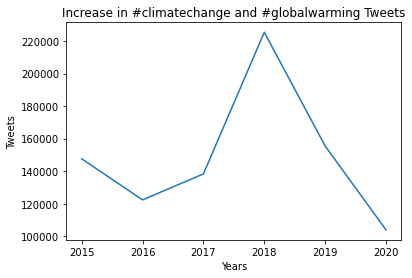

In [42]:
%matplotlib inline
tweets_list = []
years = [2015, 2016, 2017, 2018, 2019, 2020]

for year in years:
    tweets_list.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year)].shape[0])

plt.xlabel('Years')
plt.ylabel('Tweets')
plt.title('Increase in #climatechange and #globalwarming Tweets')

plt.plot(years,tweets_list)


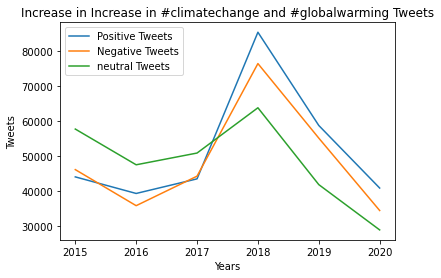

In [43]:
positive_tweets = []
negative_tweets = []
neutral_tweets = []



for year in years:
    positive_tweets.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year) & (tweets_df['Sentiment'] == 'Positive')].shape[0])
    negative_tweets.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year) & (tweets_df['Sentiment'] == 'Negative')].shape[0])
    neutral_tweets.append(tweets_df[(pd.DatetimeIndex(tweets_df['date']).year == year) & (tweets_df['Sentiment'] == 'Neutral')].shape[0])


plt.xlabel('Years')
plt.ylabel('Tweets')
plt.title('Increase in Increase in #climatechange and #globalwarming Tweets')
plt.plot(years, positive_tweets, label='Positive Tweets')
plt.plot(years, negative_tweets, label='Negative Tweets')
plt.plot(years, neutral_tweets, label='neutral Tweets')

plt.legend()

([<matplotlib.patches.Wedge at 0x7fd4f0df1d90>,
 [Text(0.7555783204844118, 1.4668338016332854, 'Positive'),
  Text(-1.6460606622103495, -0.11394865652400649, 'Neutral'),
  Text(0.8550736312778598, -1.4111516874855428, 'Negative')],
 [Text(0.4121336293551336, 0.8000911645272464, '34.86%'),
  Text(-0.8978512702965542, -0.06215381264945807, '32.48%'),
  Text(0.4664037988788326, -0.7697191022648413, '32.66%')])

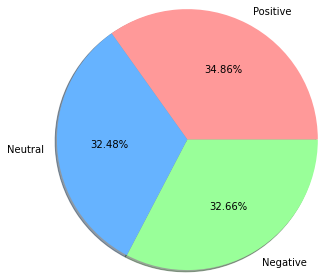

In [49]:
# pie chart of sentiments 
pie_labels = ['Positive', 'Neutral', 'Negative']
pie_values = [tweets_df[tweets_df['Sentiment'] == 'Positive'].shape[0], tweets_df[tweets_df['Sentiment'] == 'Neutral'].shape[0], tweets_df[tweets_df['Sentiment'] == 'Negative'].shape[0]]

plt.pie(pie_values, labels=pie_labels, radius=1.5, autopct='%0.2f%%', shadow=True, colors=['#ff9999','#66b3ff','#99ff99'])

In [71]:
# Tokenisation of tweets and remove stop words
stop_words.extend(['rt', 'amp'])
def tokenize_tweet(tweet):

    # print('clean_tweet::',clean_tweet)
    token_list = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles= True).tokenize(tweet)
    clean_tweet = [w for w in token_list if not w.lower() in stop_words]
    return clean_tweet
tweets_df['Tokenised'] = tweets_df['content'].apply(lambda text: tokenize_tweet(text))

In [41]:
def tweet_token_cloud(tweet_list):
    comment_words = ''
    for tokens in tweet_list:

    # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    return comment_words


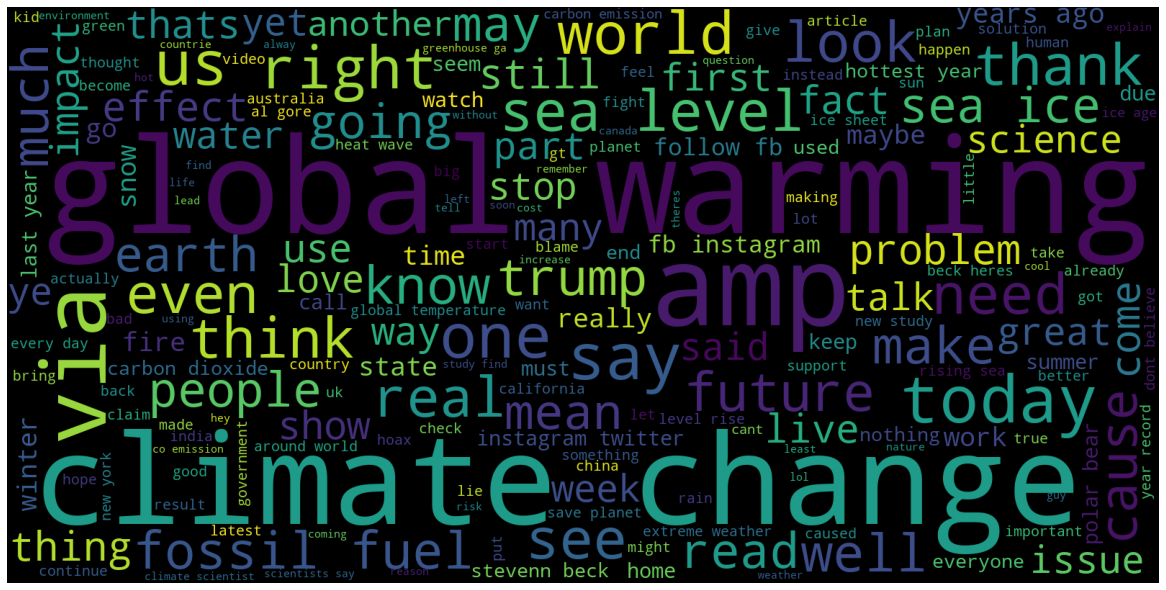

In [44]:
# Creating Word Cloud for all the tweets
stopwords = set(STOPWORDS)

stopwords.update(['rt']) 
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 15).generate(tweet_token_cloud(tweets_df['Tokenised']))
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [72]:
id2word = corpora.Dictionary(tweets_df['Tokenised'])

# Creating Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in tweets_df['Tokenised']]

In [73]:
# LDA mode training

from pprint import pprint

# Set Number of Topics

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6)


In [74]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, corpus, id2word)

/Users/yashikasorathiaicloud.com/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.082203 -0.008481       1        1  20.026523
0     -0.041645  0.105976       2        1  18.249253
5     -0.009834 -0.158719       3        1  17.172227
4      0.195160  0.069020       4        1  16.325078
1     -0.070499 -0.131136       5        1  14.203948
3     -0.155386  0.123340       6        1  14.022970, topic_info=         Term          Freq         Total Category  logprob  loglift
157   warming  61125.000000  61125.000000  Default  30.0000  30.0000
252    global  70266.000000  70266.000000  Default  29.0000  29.0000
49    climate  78145.000000  78145.000000  Default  28.0000  28.0000
48     change  70968.000000  70968.000000  Default  27.0000  27.0000
67        ice  23982.000000  23982.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
150      heat   3608.628115  16107.532860   Topic6  -5.6470   0.4685
200   weather   3331.918684  19013.022453   Topic6  -5.7268   0.2229
784      help   3067.385671  14917.180309   Topic6  -5.8095   0.3828
1184    first   2667.278355  10058.312165   Topic6  -5.9493   0.6371
921      must   2772.402447  12900.964035   Topic6  -5.9106   0.4269

[632 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13017      2  0.008116     abraham
13017      4  0.002705     abraham
13017      6  0.990134     abraham
1201       1  0.003274      accord
1201       2  0.027281      accord
...      ...       ...         ...
1141       2  0.008149  yesterdays
1141       3  0.006895  yesterdays
1141       4  0.961543  yesterdays
1141       5  0.020058  yesterdays
1141       6  0.000627  yesterdays

[2113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 5, 2, 4])

In [87]:
# Topic modeling on negative tweets
id2word_negative = corpora.Dictionary(tweets_df[tweets_df['Sentiment'] == 'Negative']['Tokenised'])

# Creating Term Document Frequency 
corpus_negative = [id2word_negative.doc2bow(text) for text in tweets_df[tweets_df['Sentiment'] == 'Negative']['Tokenised']]

/Users/yashikasorathiaicloud.com/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yashikasorathiaicloud.com/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yashikasorathiaicloud.com/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yashikasorathiaicloud.com/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import rel

In [57]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False): 
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    
    model: the LDA model
    corpus: the documents
    kwords: if True adds and returns the keys
    '''
    top_dist =[]
    keys = []
    for d in corpus:
        tmp = {i:0 for i in range(6)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.asarray(vals)]
        if kwords:
            keys += [np.asarray(vals).argmax()]

    return np.asarray(top_dist), keys

In [ ]:
top_dist, lda_keys= get_doc_topic_dist(lda_model, corpus, True)
tweets_df['Topic'] = pd.DataFrame(lda_keys)